# Model Candidates and Justification

Based on the ACF and PACF analysis after applying seasonal differencing (D=1, s=12), I suggest the following **parsimonious models**, which aim to capture the main dynamics with minimal complexity:

- $SARIMA(1,0,1)(0,1,0)_{12}$ 
- $SARIMA(1,0,1)(0,1,0)_{12}$
- $SARIMA(1,0,1)(0,1,0)_{12}$

However, to evaluate whether the seasonal structure might have been **underestimated**, I will also test more **complex seasonal models** that include additional seasonal AR or MA terms:

- $SARIMA(1,0,1)(1,1,0)_{12}$  
- $SARIMA(1,0,1)(0,1,1)_{12}$ 
- $SARIMA(1,0,1)(1,1,1)_{12}$


In [185]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

## Models fitting

In [ ]:
serie_original = pd.read_parquet("../Data/clean_data.parquet")
serie_original = pd.Series(serie_original["value"], name="AverageTemperature")
serie_original.index = pd.DatetimeIndex(serie_original.index)
serie = serie_original.asfreq("MS")
serie = serie.interpolate().round(2)
serie.sample(10)

date
2020-09-01    17.60
2023-06-01    22.10
2020-04-01     8.90
2019-01-01    -3.40
2018-11-01     0.90
2018-03-01     4.30
2020-03-01     5.80
2023-12-01     0.50
2017-09-01    15.13
2018-08-01    21.90
Name: AverageTemperature, dtype: float64

In [94]:
df = serie.to_frame()
df.to_parquet("../Data/processed_series.parquet")

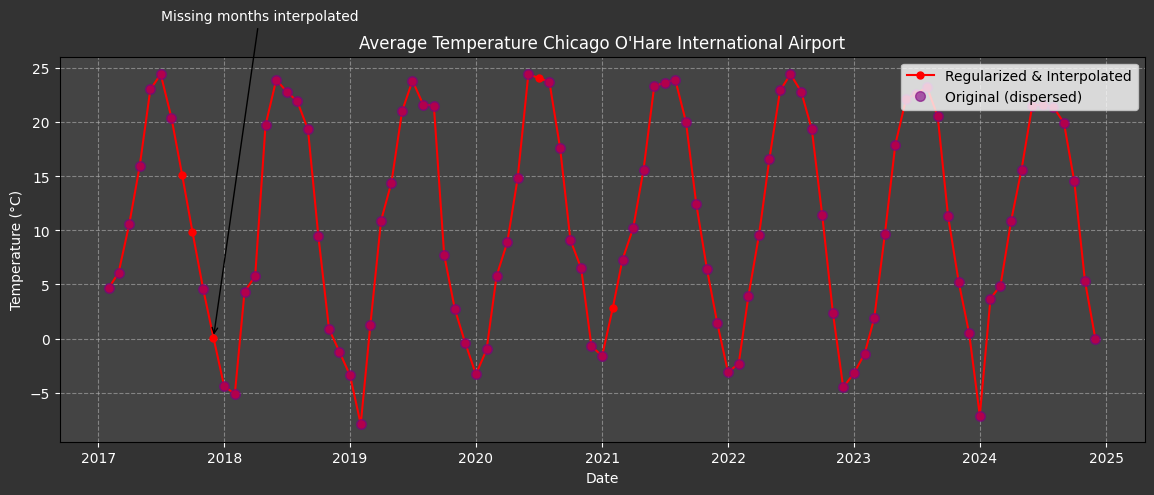

In [92]:
with plt.style.context('seaborn-v0_8-dark-palette'):
    fig, ax = plt.subplots(figsize=(14, 5), facecolor="#333333")
    ax.set_facecolor("#444444")

    # Serie interpolada con línea continua y puntos rellenos
    ax.plot(serie.index, serie, marker='o', linestyle='-', color="red", label='Regularized & Interpolated', markersize=5)
    
    # Serie original con puntos sin relleno y transparencia
    ax.plot(serie_original.index, serie_original, marker='o', linestyle='None', color="purple", alpha=0.6, label='Original (dispersed)', markersize=7)

    ax.set_title("Average Temperature Chicago O'Hare International Airport", color='white')
    ax.set_ylabel('Temperature (°C)', color='white')
    ax.set_xlabel('Date', color='white')

    ax.legend(loc='upper right')

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(colors='white')

    # Anotación para explicar los datos faltantes
    ax.annotate('Missing months interpolated', 
                xy=(serie.index[10], serie.iloc[10]), 
                xytext=(serie.index[5], serie.max()+5),
                arrowprops=dict(facecolor='white', arrowstyle='->'),
                color='white', fontsize=10)

    plt.savefig("../Outputs/Figures/temperature_comparison.png")
    plt.show()

In [144]:
models = {
    "SARIMA_(1,0,1)_(0,1,0)": ((1,0,1), (0,1,0,12)),
    "SARIMA_(0,0,1)_(0,1,0)": ((0,0,1), (0,1,0,12)),
    "SARIMA_(1,0,0)_(0,1,0)": ((1,0,0), (0,1,0,12)),
    "SARIMA_(1,0,1)_(1,1,0)": ((1,0,1), (1,1,0,12)),
    "SARIMA_(1,0,1)_(0,1,1)": ((1,0,1), (0,1,1,12)),
    "SARIMA_(1,0,1)_(1,1,1)": ((1,0,1), (1,1,1,12)),
}

results = {}

for name, (order, seasonal_order) in models.items():
    print(f'Fitting {name}')
    model = SARIMAX(serie, order=order, seasonal_order=seasonal_order, 
                    enforce_stationarity=False, enforce_invertibility=False)
    results[name] = model.fit()

Fitting SARIMA_(1,0,1)_(0,1,0)
Fitting SARIMA_(0,0,1)_(0,1,0)
Fitting SARIMA_(1,0,0)_(0,1,0)
Fitting SARIMA_(1,0,1)_(1,1,0)
Fitting SARIMA_(1,0,1)_(0,1,1)
Fitting SARIMA_(1,0,1)_(1,1,1)


## Residual Analysis (Comparing Models)

In [145]:
residuals = {}
for name in results:
    residuals[name] = results[name].resid

### Residuals close to zero (mean ≈ 0)

In [146]:
for name, resid in residuals.items():
    print(f"{name}: Mean = {resid.mean():.4f}, Std = {resid.std():.4f}")

SARIMA_(1,0,1)_(0,1,0): Mean = 1.3913, Std = 5.5454
SARIMA_(0,0,1)_(0,1,0): Mean = 1.3893, Std = 5.4456
SARIMA_(1,0,0)_(0,1,0): Mean = 1.3862, Std = 5.4434
SARIMA_(1,0,1)_(1,1,0): Mean = 1.7633, Std = 6.0004
SARIMA_(1,0,1)_(0,1,1): Mean = 1.6751, Std = 5.8901
SARIMA_(1,0,1)_(1,1,1): Mean = 1.9142, Std = 6.7209


In [147]:
for name, resid in residuals.items():
    stat, pval = ttest_1samp(resid, popmean=0)
    if pval < 0.05:
        status = "❌ Mean ≠ 0 (bad residuals)"
    else:
        status = "✅ Mean ≈ 0 (good residuals)"
    
    print(f"{name}: t-stat = {stat:.4f}, p-value = {pval:.4f} → {status}")

SARIMA_(1,0,1)_(0,1,0): t-stat = 2.4453, p-value = 0.0163 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(0,0,1)_(0,1,0): t-stat = 2.4866, p-value = 0.0147 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(1,0,0)_(0,1,0): t-stat = 2.4820, p-value = 0.0148 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(1,0,1)_(1,1,0): t-stat = 2.8642, p-value = 0.0052 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(1,0,1)_(0,1,1): t-stat = 2.7719, p-value = 0.0067 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(1,0,1)_(1,1,1): t-stat = 2.7760, p-value = 0.0066 → ❌ Mean ≠ 0 (bad residuals)


## Model Rethinking After Residual Diagnostics


Although the ADF test suggested the series was stationary (p-value < 0.05), the initial SARIMA models with `d=0` yielded residuals with a high mean and relatively high variance. This indicated that some trend or structure remained unaccounted for.

As a result, I introduced a non-seasonal differencing (`d=1`). The model `SARIMA(1,1,1)(0,1,0)[12]` produced residuals with a mean closer to zero and significantly reduced variance, indicating a much better fit.

This shows that despite statistical stationarity, the model benefits from differencing to capture hidden trends or reduce structural bias in the residuals.

So I decided to test the same models again, but this time applying a non-seasonal differencing (`d=1`), with the expectation that this adjustment would improve model performance.

The updated list of candidate models is:

- $SARIMA(1,1,1)(0,1,0)_{12}$  
- $SARIMA(1,1,0)(0,1,0)_{12}$  
- $SARIMA(0,1,1)(0,1,0)_{12}$  
- $SARIMA(1,1,1)(1,1,0)_{12}$  
- $SARIMA(1,1,1)(0,1,1)_{12}$  
- $SARIMA(1,1,1)(1,1,1)_{12}$  

## Model Rethinking: Fitting with Non-Seasonal Differencing

In [148]:
serie = pd.read_parquet("../Data/processed_series.parquet")
serie = pd.Series(serie["AverageTemperature"], name="AverageTemperature")
serie.index = pd.DatetimeIndex(serie.index)
serie = serie.asfreq("MS")
freq = pd.infer_freq(serie.index)
print(f"Frecuencia inferida: {freq}")
serie.sample(10)

Frecuencia inferida: MS


date
2018-10-01     9.50
2021-06-01    23.30
2022-07-01    24.40
2022-06-01    22.90
2021-11-01     6.40
2022-11-01     2.40
2020-07-01    24.05
2020-10-01     9.10
2023-02-01    -1.40
2023-06-01    22.10
Name: AverageTemperature, dtype: float64

In [149]:
models = {
    "SARIMA_(1,1,1)_(0,1,0)": ((1,1,1), (0,1,0,12)),
    "SARIMA_(0,1,1)_(0,1,0)": ((0,1,1), (0,1,0,12)),
    "SARIMA_(1,1,0)_(0,1,0)": ((1,1,0), (0,1,0,12)),
    "SARIMA_(1,1,1)_(1,1,0)": ((1,1,1), (1,1,0,12)),
    "SARIMA_(1,1,1)_(0,1,1)": ((1,1,1), (0,1,1,12)),
    "SARIMA_(1,1,1)_(1,1,1)": ((1,1,1), (1,1,1,12)),
}

results = {}

for name, (order, seasonal_order) in models.items():
    print(f'Fitting {name}')
    model = SARIMAX(serie, order=order, seasonal_order=seasonal_order, 
                    enforce_stationarity=False, enforce_invertibility=False)
    results[name] = model.fit()

Fitting SARIMA_(1,1,1)_(0,1,0)
Fitting SARIMA_(0,1,1)_(0,1,0)
Fitting SARIMA_(1,1,0)_(0,1,0)
Fitting SARIMA_(1,1,1)_(1,1,0)
Fitting SARIMA_(1,1,1)_(0,1,1)
Fitting SARIMA_(1,1,1)_(1,1,1)


## Model Rethinking: Residual Analysis (Comparing Models)

In [151]:
residuals = {}
for name in results:
    residuals[name] = results[name].resid

### Residuals close to zero (mean ≈ 0)

In [152]:
for name, resid in residuals.items():
    print(f"{name}: Mean = {resid.mean():.4f}, Std = {resid.std():.4f}")

SARIMA_(1,1,1)_(0,1,0): Mean = 0.4845, Std = 3.2043
SARIMA_(0,1,1)_(0,1,0): Mean = 0.3178, Std = 3.2318
SARIMA_(1,1,0)_(0,1,0): Mean = 0.0589, Std = 3.5365
SARIMA_(1,1,1)_(1,1,0): Mean = 0.2598, Std = 3.1797
SARIMA_(1,1,1)_(0,1,1): Mean = 0.0942, Std = 2.8965
SARIMA_(1,1,1)_(1,1,1): Mean = 0.1885, Std = 3.1331


In [153]:
for name, resid in residuals.items():
    stat, pval = ttest_1samp(resid, popmean=0)
    if pval < 0.05:
        status = "❌ Mean ≠ 0 (bad residuals)"
    else:
        status = "✅ Mean ≈ 0 (good residuals)"
    
    print(f"{name}: t-stat = {stat:.4f}, p-value = {pval:.4f} → {status}")

SARIMA_(1,1,1)_(0,1,0): t-stat = 1.4739, p-value = 0.1439 → ✅ Mean ≈ 0 (good residuals)
SARIMA_(0,1,1)_(0,1,0): t-stat = 0.9586, p-value = 0.3402 → ✅ Mean ≈ 0 (good residuals)
SARIMA_(1,1,0)_(0,1,0): t-stat = 0.1624, p-value = 0.8713 → ✅ Mean ≈ 0 (good residuals)
SARIMA_(1,1,1)_(1,1,0): t-stat = 0.7963, p-value = 0.4279 → ✅ Mean ≈ 0 (good residuals)
SARIMA_(1,1,1)_(0,1,1): t-stat = 0.3170, p-value = 0.7520 → ✅ Mean ≈ 0 (good residuals)
SARIMA_(1,1,1)_(1,1,1): t-stat = 0.5865, p-value = 0.5590 → ✅ Mean ≈ 0 (good residuals)


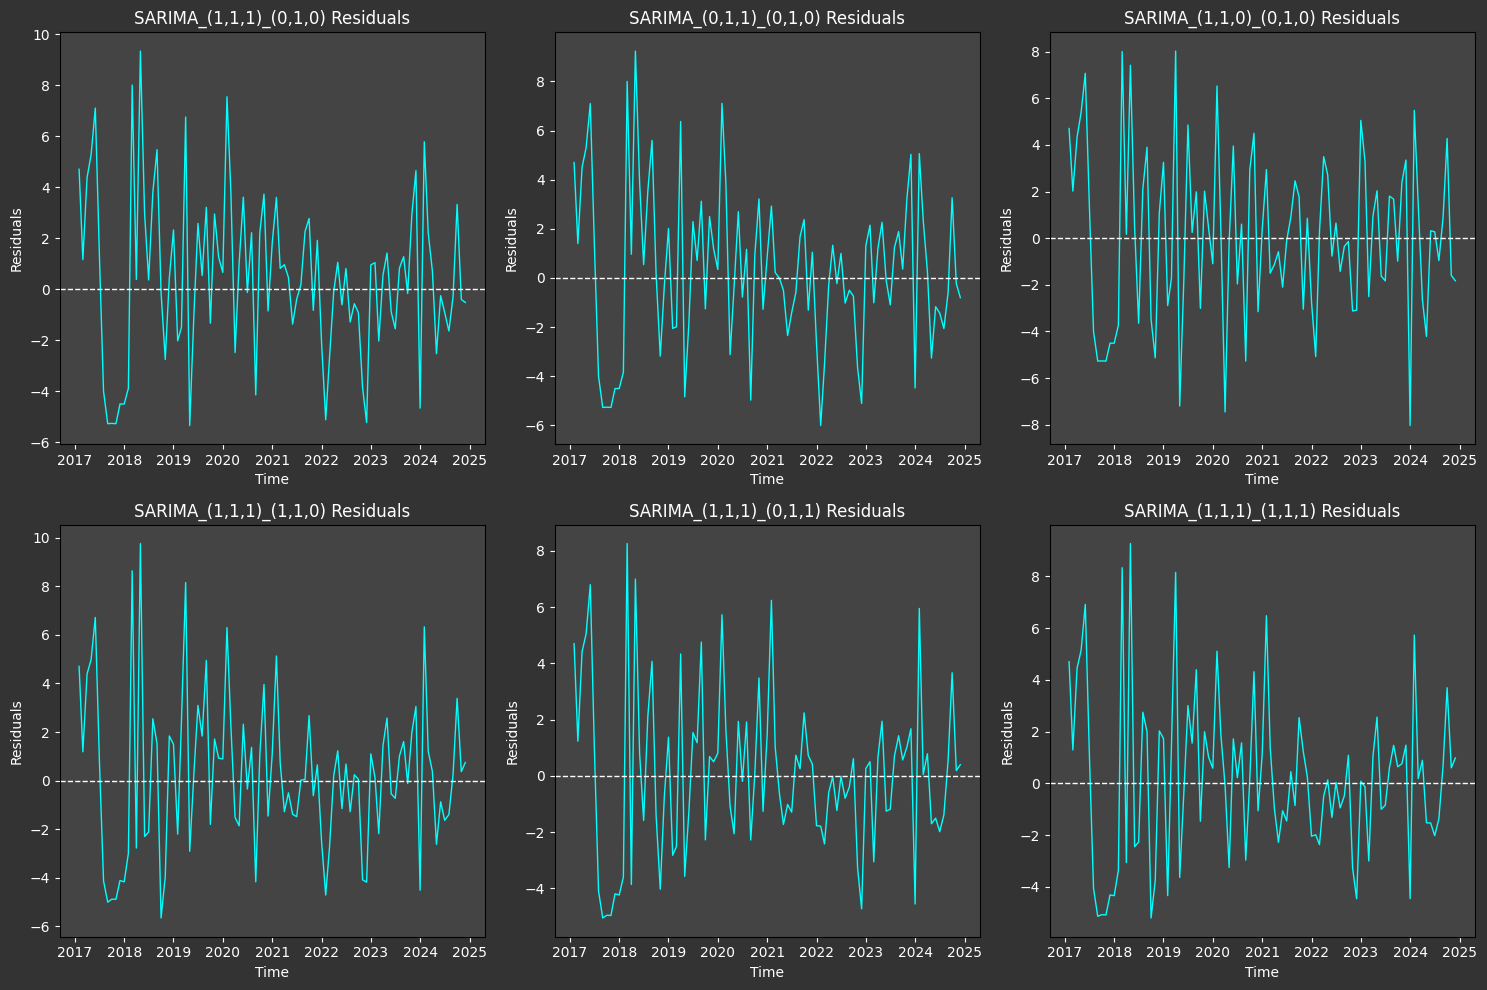

In [169]:
with plt.style.context('seaborn-v0_8-dark-palette'):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), facecolor="#333333")
    axs = axs.flatten()

    for i, (name, resid) in enumerate(residuals.items()):
        ax = axs[i]
        ax.plot(resid, color='cyan', lw=1)
        ax.axhline(0, color='white', ls='--', lw=1)
        ax.set_title(f"{name} Residuals", color='white')
        ax.set_facecolor("#444444")
        ax.tick_params(colors='white')
        ax.set_xlabel("Time", color='white')
        ax.set_ylabel("Residuals", color='white')

    # Si sobran subplots, los ocultas
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    plt.savefig("../Outputs/Figures/residuals")
    plt.tight_layout()
    plt.show()

### Stationarity and Invertibility of the Model

In [164]:
summary = []

for name, result in results.items():
    ar_roots = result.arroots
    ma_roots = result.maroots

    is_stationary = all(abs(root) > 1 for root in ar_roots)
    is_invertible = all(abs(root) > 1 for root in ma_roots)
    summary.append({
        "Model": name,
        "Stationary": is_stationary,
        "Invertible": is_invertible
    })

df_summary = pd.DataFrame(summary)
df_summary

,Model,Stationary,Invertible
0,"SARIMA_(1,1,1)_(0,1,0)",True,False
1,"SARIMA_(0,1,1)_(0,1,0)",True,True
2,"SARIMA_(1,1,0)_(0,1,0)",True,True
3,"SARIMA_(1,1,1)_(1,1,0)",True,True
4,"SARIMA_(1,1,1)_(0,1,1)",True,True
5,"SARIMA_(1,1,1)_(1,1,1)",True,True


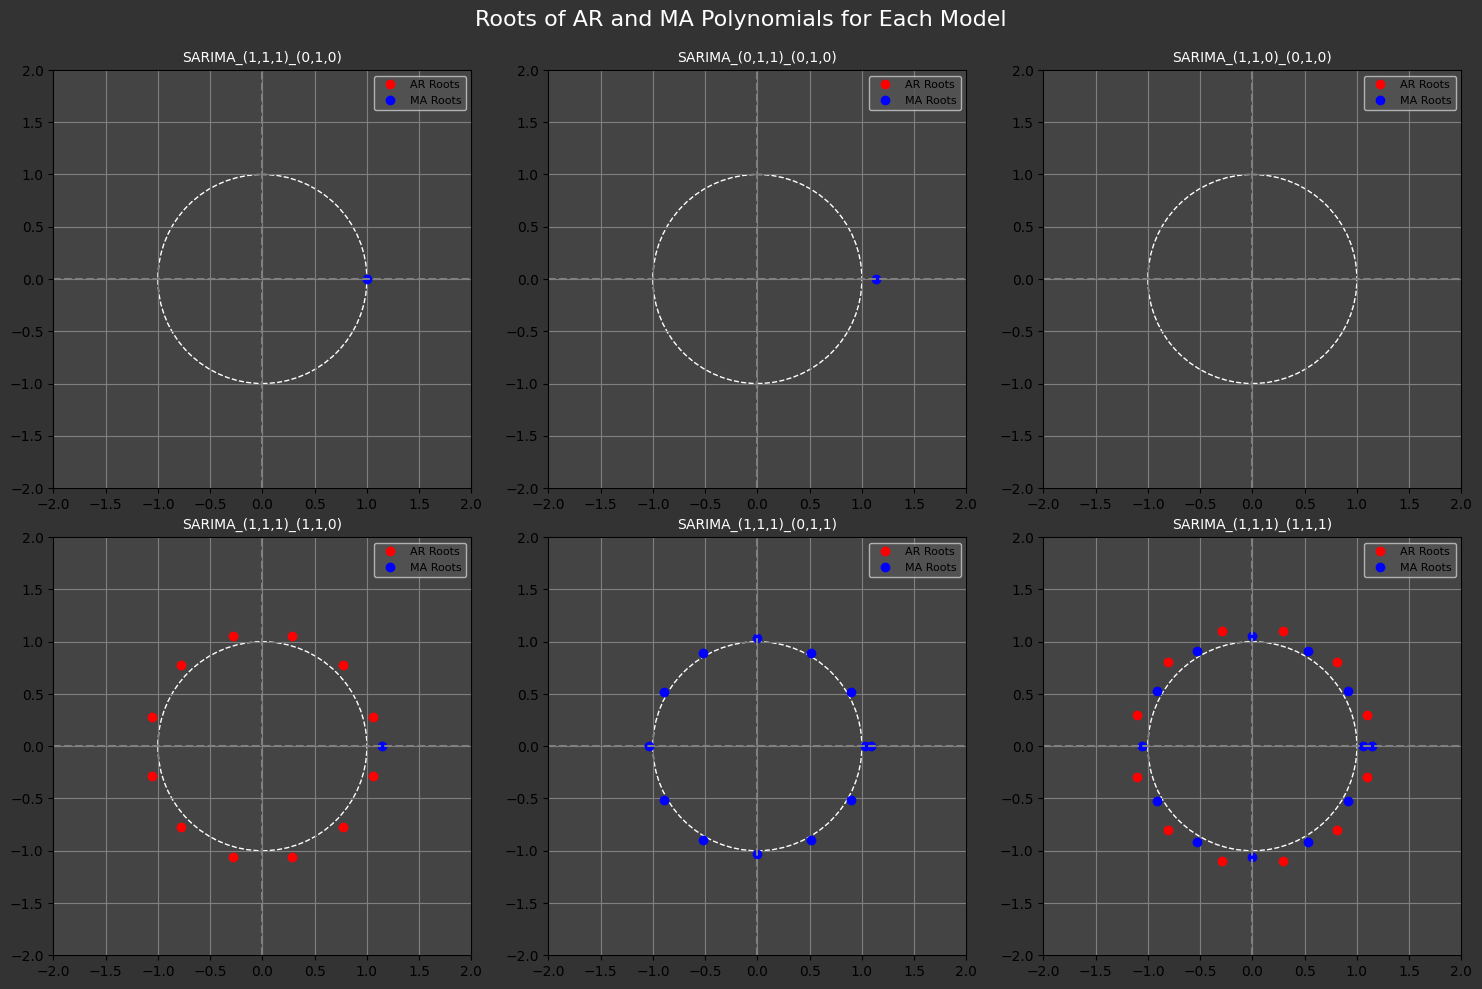

In [167]:
models = list(results.items())
n = len(models)
cols = 3
rows = (n + cols - 1) // cols

with plt.style.context('seaborn-v0_8-dark-palette'):
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), facecolor="#333333")
    axs = axs.flatten()

    for i, (name, result) in enumerate(models):
        ax = axs[i]
        ax.set_facecolor("#444444")

        # Círculo unitario
        circle = plt.Circle((0, 0), 1, color='white', fill=False, linestyle='--')
        ax.add_artist(circle)

        # Raíces
        ax.plot(result.arroots.real, result.arroots.imag, 'ro', label='AR Roots')
        ax.plot(result.maroots.real, result.maroots.imag, 'bo', label='MA Roots')

        ax.axhline(0, color='gray', linestyle='--')
        ax.axvline(0, color='gray', linestyle='--')
        ax.set_title(name, fontsize=10, color='white')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')
        ax.grid(True, color='gray')
        ax.legend(loc='upper right', fontsize=8, facecolor="#555555")

    # Quitar subplots vacíos
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle("Roots of AR and MA Polynomials for Each Model", fontsize=16, color='white')
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig("../Outputs/Figures/sationary_invertible_models")
    plt.show()



I discarded the first model, $SARIMA(1,1,1)(0,1,0)_{12}$, because it is not invertible. Therefore, it cannot be considered a valid candidate for further analysis.


In [173]:
model_to_remove = 'SARIMA_(1,1,1)_(0,1,0)'
if model_to_remove in results:
    removed = results.pop(model_to_remove)
    print(f"Removed model: {model_to_remove}\n")

if model_to_remove in residuals:
    removed = residuals.pop(model_to_remove)
    print(f"Removed model: {model_to_remove}\n")

Removed model: SARIMA_(1,1,1)_(0,1,0)

Removed model: SARIMA_(1,1,1)_(0,1,0)



### Homoscedasticity (constant variance)

In [188]:
print("White Test for Heteroscedasticity\n")

for name, result in results.items():
    resid = result.resid
    # Variables explicativas para la regresión auxiliar (usamos predicciones y su cuadrado)
    exog = pd.DataFrame({
        'fitted': result.fittedvalues,
        'fitted_sq': result.fittedvalues**2
    })
    # arma la matriz de diseño con constante para la regresión auxiliar
    exog = sm.add_constant(exog)
    
    # Prueba White: regresa (LM stat, LM p-value, F stat, F p-value)
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_white(resid, exog)
    
    print(f"Model: {name}")
    print(f"  LM Statistic: {lm_stat:.4f}, LM p-value: {lm_pvalue:.4f}")
    print(f"  F Statistic:  {f_stat:.4f}, F p-value:  {f_pvalue:.4f}")
    if lm_pvalue < 0.05:
        print("  → ❌ Evidence of heteroscedasticity (reject H0 of homoscedasticity)")
    else:
        print("  → ✅ No evidence of heteroscedasticity (fail to reject H0)")
    print()

White Test for Heteroscedasticity

Model: SARIMA_(0,1,1)_(0,1,0)
  LM Statistic: 9.5409, LM p-value: 0.0489
  F Statistic:  2.5120, F p-value:  0.0471
  → ❌ Evidence of heteroscedasticity (reject H0 of homoscedasticity)

Model: SARIMA_(1,1,0)_(0,1,0)
  LM Statistic: 6.4420, LM p-value: 0.1685
  F Statistic:  1.6367, F p-value:  0.1719
  → ✅ No evidence of heteroscedasticity (fail to reject H0)

Model: SARIMA_(1,1,1)_(1,1,0)
  LM Statistic: 8.0860, LM p-value: 0.0885
  F Statistic:  2.0933, F p-value:  0.0882
  → ✅ No evidence of heteroscedasticity (fail to reject H0)

Model: SARIMA_(1,1,1)_(0,1,1)
  LM Statistic: 13.7841, LM p-value: 0.0080
  F Statistic:  3.8187, F p-value:  0.0065
  → ❌ Evidence of heteroscedasticity (reject H0 of homoscedasticity)

Model: SARIMA_(1,1,1)_(1,1,1)
  LM Statistic: 8.9667, LM p-value: 0.0619
  F Statistic:  2.3450, F p-value:  0.0606
  → ✅ No evidence of heteroscedasticity (fail to reject H0)



I discarded the following models, $SARIMA(0,1,1)(0,1,0)_{12}$, $SARIMA(1,1,1)(0,1,1)_{12}$, because their residuals exhibit heteroscedasticity. Therefore, they cannot be considered valid candidates for further analysis.

In [190]:
model_to_remove = ["SARIMA_(0,1,1)_(0,1,0)", "SARIMA_(1,1,1)_(0,1,1)"]
for m in model_to_remove:
    if m in results:
        removed = results.pop(m)
        print(f"Removed model: {m}\n")
    if m in residuals:
        removed = residuals.pop(m)
        print(f"Removed model: {m}\n")

Removed model: SARIMA_(0,1,1)_(0,1,0)

Removed model: SARIMA_(0,1,1)_(0,1,0)

Removed model: SARIMA_(1,1,1)_(0,1,1)

Removed model: SARIMA_(1,1,1)_(0,1,1)



### Normality of Residuals